In [29]:
import pandas as pd 
import gzip 
from tqdm import tqdm
import matplotlib.pyplot as plt
import re
import string
import pickle as pkl
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


In [3]:
DATA_FOLDER='data/'

In [4]:
#borrowed from the same page
def parse(path):
    g = gzip.open(path, 'rb') 
    for l in g:
        yield eval(l) 
def getDF(path):
    i = 0 
    df = {} 
    for d in tqdm(parse(path)):
        df[i] = d 
        i += 1 
    return pd.DataFrame.from_dict(df, orient='index') 

In [5]:
df = getDF('raw_data/reviews_Kindle_Store_5.json.gz') 

982619it [00:56, 17311.74it/s]


In [16]:
data=df[['reviewText','overall']].copy()

In [17]:
data.overall=data.overall.astype('int')


In [25]:
data['length']=data.reviewText.apply(len)

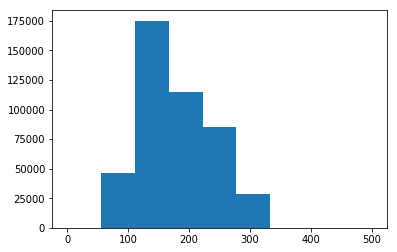

In [9]:
import numpy as np
plt.hist(data.reviewText.apply(len),bins=np.linspace(0,500,10))
plt.show()

we will only use records of length between 50 and 300
that will give us around 450111 records (almost half)

In [39]:
mask=(data.reviewText.str.len()>50) & (data.reviewText.str.len()<300)

In [42]:
data=data.loc[mask]

In [46]:
data=data.drop(['length'],axis=1)

In [51]:
trans_vals='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~'
def clean_data(dataset):
    with_expansions=list()
    trans_table=str.maketrans('','',trans_vals)
    dataset.reviewText = dataset.reviewText.apply(lambda x: x.lower())
    for line in tqdm(dataset.reviewText.values):
        clean_line=[w.translate(trans_table) for w in line.split(' ')]
        var=re.sub(' +',' ',' '.join(clean_line))
        with_expansions.append(var)
    return with_expansions

In [52]:
cleaned_data=clean_data(data)

100%|██████████| 450111/450111 [00:14<00:00, 30228.70it/s]


In [55]:
data['clean_text']=cleaned_data

In [99]:
del cleaned_data

you can see that preprocessing modified the original data because the function modified a reference to the dataframe
we don't need that anymore so drop it

In [59]:
data=data.drop(['clean_text'],axis=1)

In [5]:
# loads data from a pickle file
def load_dataset(filename):
    with open(DATA_FOLDER+filename,'rb') as handle:
        dataset = pkl.load(handle)
    return dataset


# saves updated dataset
def save_dataset(dataset,filename):
    with open(DATA_FOLDER+filename, 'wb') as handle:
        pkl.dump(dataset, handle)

        # save tokenizer
def save_tokenizer(tokenizer):
    with open('misc/tokenizer.pkl', 'wb') as handle:
        pkl.dump(tokenizer, handle)



In [102]:
save_dataset(data,'std-clean-data.pkl')

In [7]:
data=load_dataset('std-clean-data.pkl')

time to tokenize the text

In [107]:
tokenizer = Tokenizer(num_words=20000, split=' ')
tokenizer.fit_on_texts(data.reviewText.values)
save_tokenizer(tokenizer)

In [108]:
data['tokenized'] = tokenizer.texts_to_sequences(data.reviewText.values)

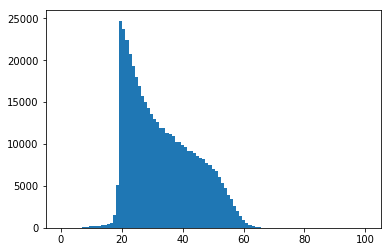

In [109]:
plt.hist(data.tokenized.apply(len),bins=np.linspace(0,100,100))
plt.show()

In [10]:
max(data.tokenized.apply(len))

72

In [112]:
del tokenizer

In [22]:
padded_ = pad_sequences(data.tokenized,maxlen=80,padding='post')

In [23]:
padded_.shape

(450111, 80)

In [24]:
X=padded_

In [35]:
y= pd.get_dummies(data.overall)


In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33)

In [37]:
save_dataset([X_train, X_test, Y_train, Y_test],'final_data.pkl')

In [38]:
Y_test.shape

(148537, 5)